# Synthetic data TG 
This notebook uses the code that Ethan wrote to try to invert for the taylor-goldstein equation with synthetic data

In [191]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from scipy.optimize import ridder
import numpy as np
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary
from DTS_to_displacement import DTS_to_disp, get_coefs

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

## Internal wave eigenproblem for $U(z)=0$

$$W_n'' + k_n^2 \frac{N^2(z)-\omega^2}{\omega^2-f^2}W_n = 0$$

$$\rightarrow \frac{d\mathbf{y}}{dz} = \begin{bmatrix} 0 & -k^2 \frac{N^2(z)-\omega^2}{\omega^2-f^2} \\ 1 & 0 \end{bmatrix} \mathbf{y} \qquad\text{where}\qquad \mathbf{y} = \begin{bmatrix} \frac{dW}{dz} \\ W \end{bmatrix}$$

In [192]:
def dydz(y,zi,k,w,z,N,f):
    N_ = np.interp(zi,z,N)
    A = np.array([[0,-k**2 * (N_**2-w**2)/(w**2-f**2)],[1,0]])
    return A @ y

def integrate(k,y0,w,z,N,f):
    # calculates y = [dW/dz,W]
    y = odeint(dydz,y0,z,args=((k,w,z,N,f)))
    return y

def evaluate(k,w,z,N,f):
    # returns only the value W(z=H)
    y0 = [1,0]
    y = integrate(k,y0,w,z,N,f)[-1,:]
    return y[1]

def dispersion(cmin,cmax,nc,w,z,N,f,all_modes=False,num_modes=10):
    y0 = np.array([1,0])
    cs = np.logspace(np.log10(cmin),np.log10(cmax),nc)
    ys = np.zeros(nc)
    for ic,c in enumerate(cs):
        k_ = w/c
        ys[ic] = evaluate(k_,w,z,N,f)
    diff = np.diff(np.sign(ys))
    brac = np.argwhere(abs(diff)>1).flatten()
    nb = np.minimum(len(brac),num_modes)
    nnb = len(brac)
    if all_modes:
        cp = []
        for ib in range(nb):
            a = w/cs[brac[nnb-ib-1]+1]
            b = w/cs[brac[nnb-ib-1]]
            k = ridder(evaluate,a,b,(w,z,N,f))
            cp.append(w/k)
    elif len(brac)>0:
        a = w/cs[brac[-1]+1]
        b = w/cs[brac[-1]]
        k = ridder(evaluate,a,b,(w,z,N,f))
        cp = w/k
    else:
        cp = np.nan
    return cp


### Case of uniform stratification ($N=const$):

$$k_n = \pm \frac{n\pi}{H} \left(\frac{\omega^2-f^2}{N^2-\omega^2}\right)^{1/2}$$
$$W_n = \sin{\left(\frac{n\pi z}{H}\right)}$$

In [193]:
## Parameters
nz = 20                      # num points to evaluate eigenfunction
H = 100                      # water depth (m)
z = np.linspace(0,H,nz)      # depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
N = 1e-2*np.ones(nz)         # buoyancy frequency (rad/s)
nw = 20
ws = np.logspace(np.log10(f+1e-5),np.log10(np.max(N)-1e-5),nw) # frequencies of interest

## Compute dispersion
cmin = 0.01 # m/s
cmax = 10
nc = 100
all_modes = True

nn = 3 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes,num_modes=3)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

In [194]:
## Analytical solution
cn = np.zeros((nw,nn))
Wn = np.zeros((nw,nz,nn))
for n in range(nn):
    cn[:,n] = ws/((np.pi*(n+1)/H)*np.sqrt((ws**2-f**2)/(N[0]**2-ws**2)))
    Wn[:,:,n] = np.sin((n+1)*np.pi*z/H)

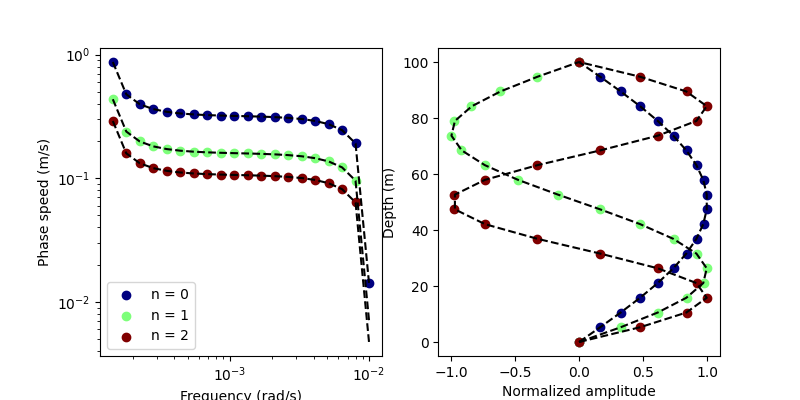

In [196]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,2,figsize=(8,4))
for n in range(nn):
    ax[0].plot(ws,cn[:,n],'k--')
    ax[0].scatter(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='lower left')

for n in range(nn):
    ax[1].plot(Wn[0,:,n],z,'k--')
    ax[1].scatter(W[0,:,n]/np.max(abs(W[0,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')

modes = W[0,:,:]
modes_depths = z

### Layered stratification

In [200]:
## Parameters
nz = 200                      # num points to evaluate eigenfunction
H = 100                      # water depth (m)
z = np.linspace(0,H,nz)      # depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
N = np.ones(nz)*1e-2              # buoyancy frequency (rad/s)
H0 = H//2
N[np.logical_and(z>=H0//4,z<=H0//2)] = 2e-2
N[np.logical_and(z>=H0//2,z<=3*H0//4)] = 1e-2
N[z>=3*H//4] = 2e-2
nw = 10
ws = np.logspace(np.log10(f+1e-5),np.log10(np.max(N)-1e-5),nw) # frequencies of interest

## Compute dispersion
cmin = 0.1 # m/s
cmax = 5
nc = 80
all_modes = True

nn = 3 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

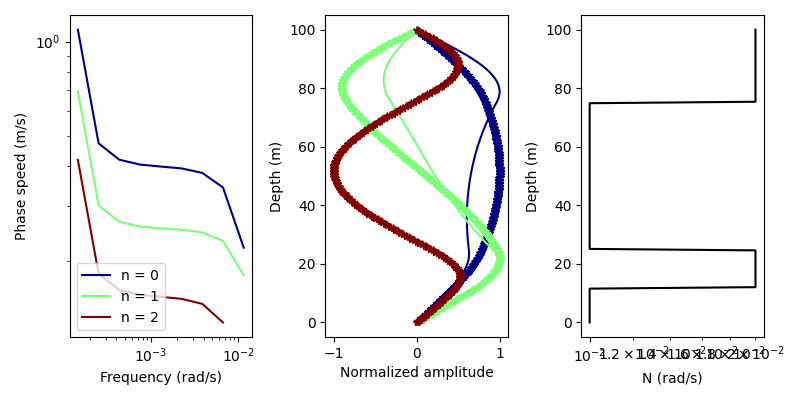

In [201]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,3,figsize=(8,4))
for n in range(nn):
    # ax[0].plot(ws,cn[:,n],'k--')
    ax[0].plot(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='lower left')

for n in range(nn):
    #ax[1].plot(Wn[0,:,n],z,'k--')
    ax[1].plot(W[0,:,n]/np.max(abs(W[0,:,n])),z,color=colors[n],marker='*')
    ax[1].plot(W[-2,:,n]/np.max(abs(W[-2,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')

ax[2].plot(N,z,'k')
ax[2].set_xlabel('N (rad/s)')
ax[2].set_ylabel('Depth (m)')
ax[2].set_xscale('log')

plt.tight_layout()

### Greenfjord N-profile

In [202]:
tmp = np.genfromtxt('../data/synthetic-data/Depth_Temp_N.csv',delimiter=',',skip_header=2)
z = tmp[:,0]
N = np.convolve(tmp[:,1],np.ones(10)/10,mode='same')
T = np.convolve(tmp[:,2],np.ones(10)/10,mode='same')

In [206]:
## Parameters
nz = len(z)                  # num points to evaluate eigenfunction
H = np.max(z)                   # water depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
#nw = 15
#ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest
ws = np.array([2*np.pi/(12*60*60),2*np.pi/(15*60)])
nw = len(ws)

## Compute dispersion
cmin = 0.05 # m/s
cmax = 2
nc = 100
all_modes = True

nn = 10 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    print(i+1,nw)
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes,num_modes=nn)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

1 2
2 2


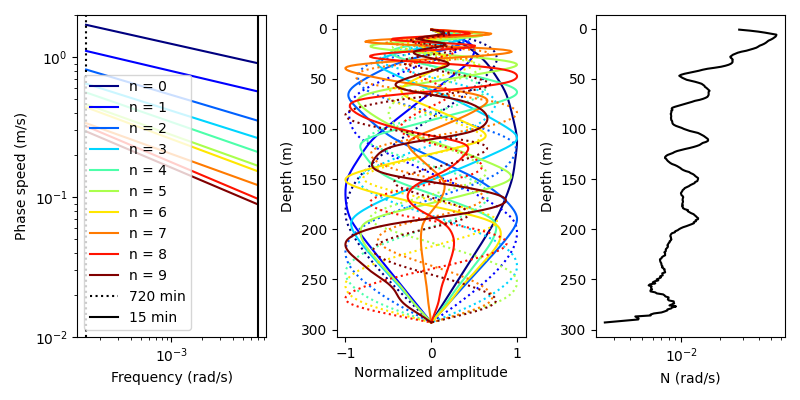

In [207]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,3,figsize=(8,4))
for n in range(nn):
    ax[0].plot(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].axvline(ws[0],c='k',linestyle=':',label='%d min'%(2*np.pi/ws[0]/60))
ax[0].axvline(ws[1],c='k',label='%d min'%(2*np.pi/ws[1]/60))
ax[0].legend(loc='lower left')

for n in range(nn):
    ax[1].plot(W[0,:,n]/np.max(abs(W[0,:,n])),z,color=colors[n],linestyle=':')
    ax[1].plot(W[1,:,n]/np.max(abs(W[1,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')



ax[2].plot(N,z,'k')
ax[2].set_xlabel('N (rad/s)')
ax[2].set_ylabel('Depth (m)')
ax[2].set_xscale('log')

ax[0].set_ylim([0.01,2])
ax[1].invert_yaxis()
ax[2].invert_yaxis()

plt.tight_layout()

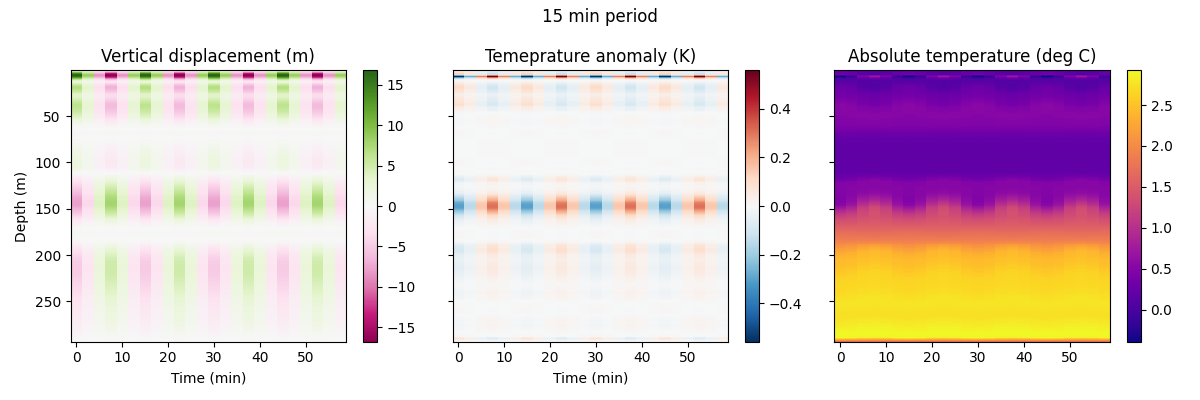

In [209]:
## Create synthetic data

# depth slice across time
dt = 150
t = np.arange(0,60*60,dt)
nt = len(t)
tt,zz = np.meshgrid(t,z)

iw = 1 # which frequency
w = ws[iw]
A = np.ones(nn)*5 # all modes get equal amplitude??
D = np.zeros(tt.shape)
dTdz = np.tile(np.gradient(T),(nt,1)).T
for n in range(nn):
    D += A[n] * np.cos(w*tt) * np.tile(W[iw,:,n]/np.max(W[iw,:,n]),(nt,1)).T 
DT = D * dTdz
DT_abs = DT + np.tile(T,(nt,1)).T

fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))
im0 = ax[0].pcolormesh(tt/60,zz,D,cmap='PiYG')
im1 = ax[1].pcolormesh(tt/60,zz,DT,cmap='RdBu_r')
im2 = ax[2].pcolormesh(tt/60,zz,DT_abs,cmap='plasma')
ax[0].set_xlabel('Time (min)')
ax[1].set_xlabel('Time (min)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Vertical displacement (m)')
ax[1].set_title('Temeprature anomaly (K)')
ax[2].set_title('Absolute temperature (deg C)')
plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
ax[1].invert_yaxis()
fig.suptitle('%d min period' % (2*np.pi/w/60))
fig.tight_layout()


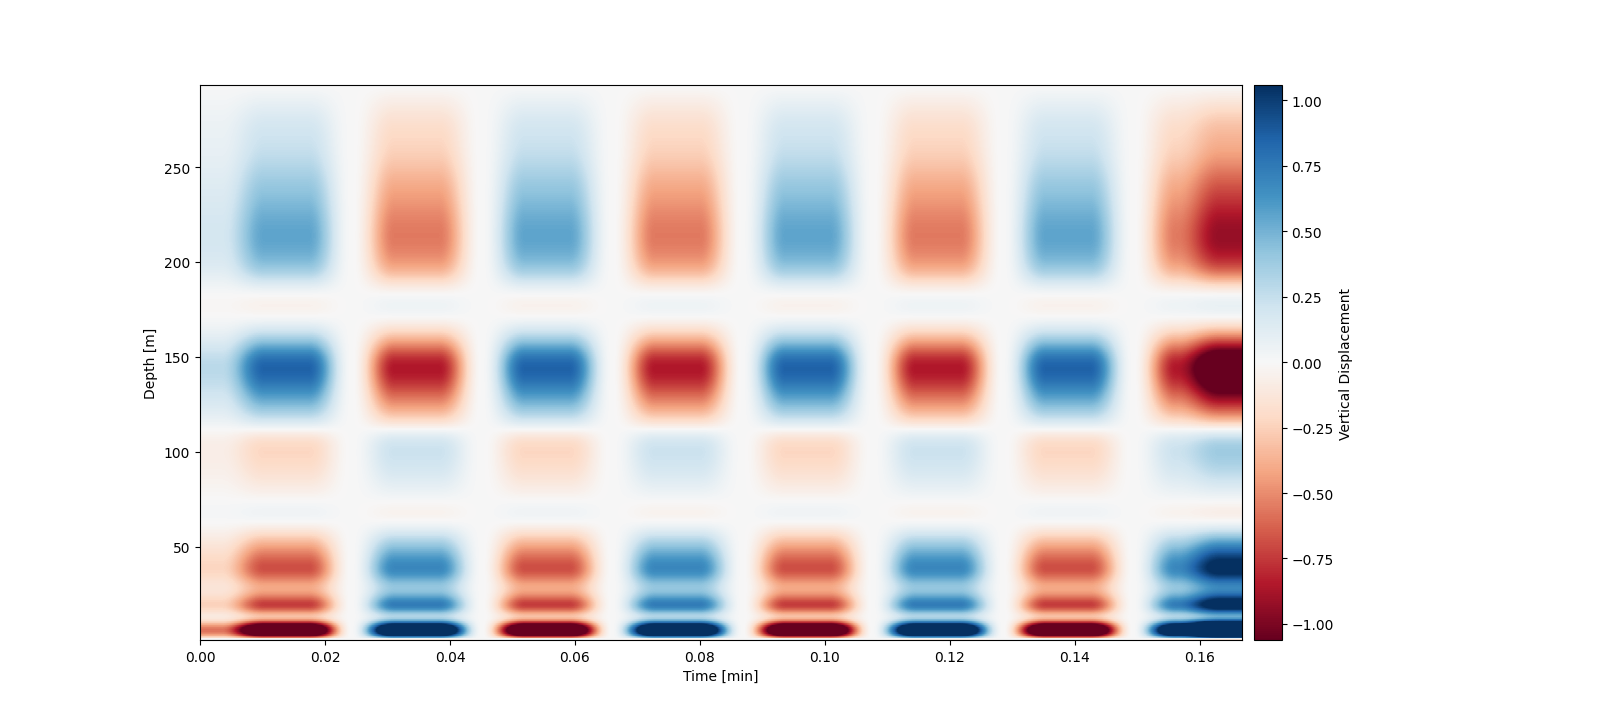

In [256]:
# Normalizing displacements and temp arrays
disps_interp = (D - np.min(D)) / (np.max(D) - np.min(D))
filtered_arr = (DT_abs - np.min(DT_abs)) / (np.max(DT_abs) - np.min(DT_abs))
# Switching to the same variable names that I've been using bc I am lazy
plot_times_zoomed = t/60
plot_dists_zoomed = z

# Plot vertical displacement over depth and time
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = ps.SmoothedFiniteDifference(axis=1)._differentiate(disps_interp, t=dt)
dddt = ps.SmoothedFiniteDifference(axis=1)._differentiate(ddt, t=dt)
im1 = ax.imshow(ddt, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='RdBu',
            vmin=np.percentile(ddt[~np.isnan(ddt)],1),
            vmax=np.percentile(ddt[~np.isnan(ddt)],99),
            )
ax.set_ylabel('Depth [m]') 
ax.set_xlabel('Time [min]')

# plt.plot(times_flattened, depths_flattened, 'ok', label="input point", markersize=0.4)
# plt.scatter(X, Y, s=0.4)
plt.plot()
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


# Set up SINDy

In [211]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

avg_temp = np.mean(filtered_arr, axis=1)

## SINDy Stuff

## Taylor Goldstein SINDy

In [212]:
window_size = 50
step_size = 30 # 20
x = plot_dists_zoomed
t = plot_times_zoomed
sparsity = 1e3

Score =  0.9318853209484764
(u)' = 1.000 (du/dt)
((du/dt))' = 0.028 1 + -0.110 uu


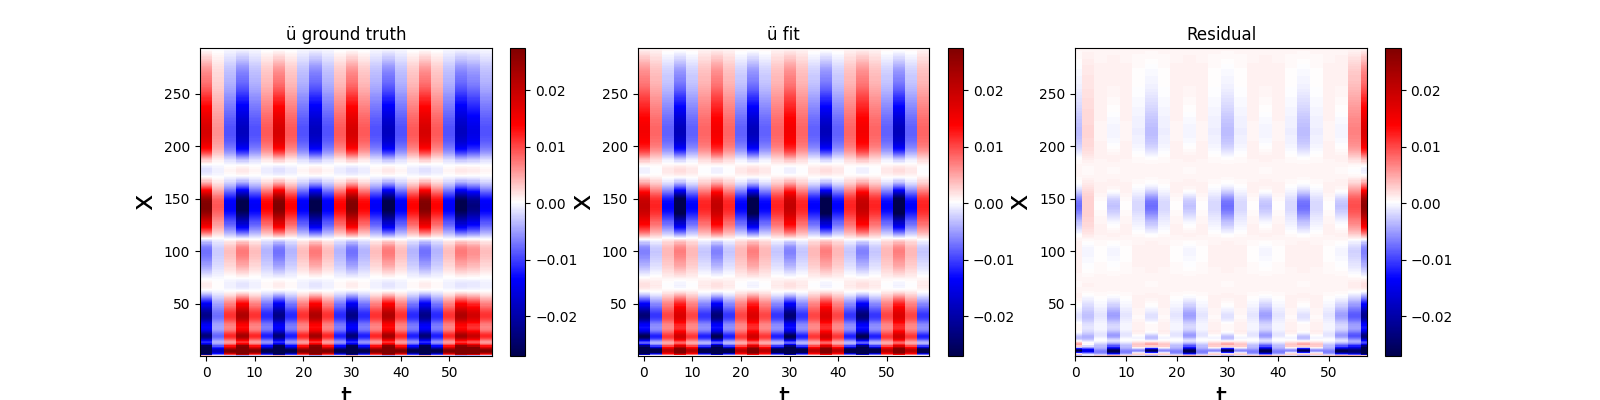

In [213]:
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = disps_interp
v_sol = ps.SmoothedFiniteDifference(axis=1)._differentiate(u_sol, t=dt)

# feature_value[:, 1] = ps.SmoothedFiniteDifference(axis=0)._differentiate(avg_temp, t=dt) 

# Setting up data array to contain both u and the derivative of u
u = np.zeros((len(x), len(t), 2))
u[:, :, 0] = u_sol
u[:, :, 1] = v_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

# Setting library functions. x = u and y = du/dt.
library_functions = [
    lambda x: x,
    lambda x: x * x,
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x, y: x * y * y
]
library_function_names = [
    lambda x: x,
    lambda x: x + x, 
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y
]

# Creating a PDE library
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
)

optimizer = ps.STLSQ(
    threshold= 5e-1, # 8e-2
    max_iter=10000,
    normalize_columns=True,
)

feat_names = ['u', '(du/dt)']

model = ps.SINDy(feature_library=pde_lib, feature_names=feat_names, optimizer=optimizer)

model.fit(u, x_dot=u_dot, quiet=True)

# Get the coefficients
coefficients = model.coefficients()

# Get the term names
feature_names = model.get_feature_names()
score = model.score(u,t=dt)
print("Score = ", score)
model.print()

u_dot_stlsq = model.predict(u)
u_dot_test = u_dot
t_test = t

min = np.percentile(u_dot_test[~np.isnan(u_dot_test[:, :, 1]), 1],1)
max = np.percentile(u_dot_test[~np.isnan(u_dot_test[:, :, 1]), 1],99)

# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t, x, u_dot_test[:, :, 1],
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü ground truth')
ax = plt.gca()

plt.subplot(1, 3, 2)
u_dot_stlsq = np.reshape(u_dot_stlsq[:, :, 1], (len(x), len(t_test)))
plt.pcolormesh(t_test, x, u_dot_stlsq,
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü fit')
ax = plt.gca()

plt.subplot(1, 3, 3)
plt.pcolormesh(t_test, x, u_dot_stlsq[:, :] - u_dot_test[:, :, 1],
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.xlim([t[0], t[-1]])
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

# Fitting modes of TG

## Sinusoidal fit, no control

Score =  -1.026861894342495
(u)' = 2.000 u
(20, 1, 1)


<>:71: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_69378/2243202327.py:71: SyntaxWarning: invalid escape sequence '\d'
  plt.title('$\dot{u}$ ground truth')


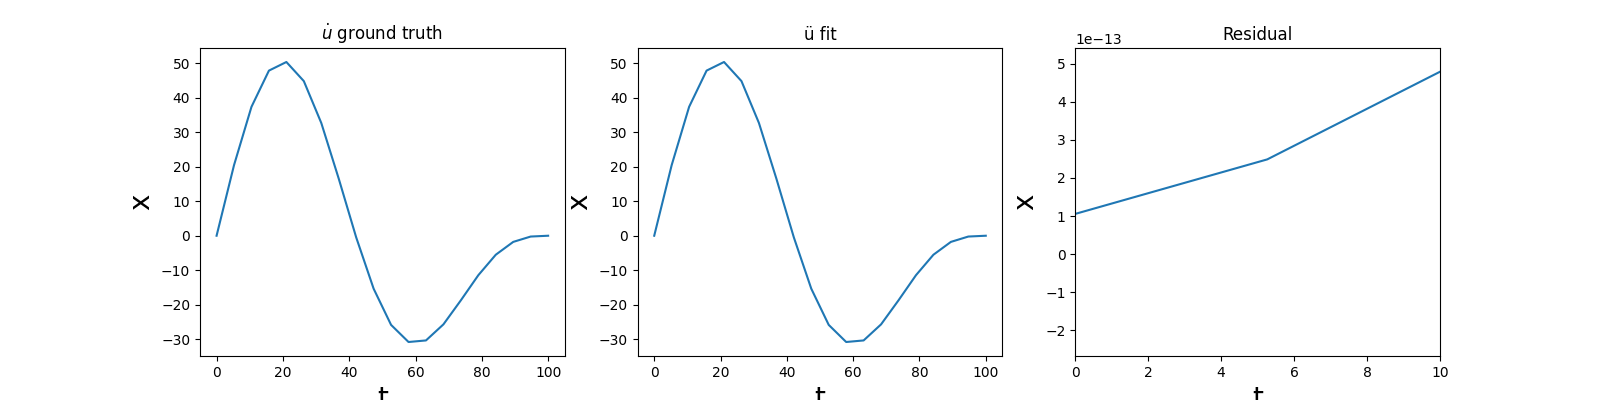

In [285]:
x = modes_depths
dx = x[1] - x[0]
u = modes[:, 1] + modes[:, 2] # /np.max(np.abs(W[0,:,n]))
omega = 2

u_sol = u

u = np.zeros((len(x)))
u[:] = u_sol
u_dot = np.zeros((len(x)))
u_dot[:] = omega * u[:]

library_functions = [
    lambda x: x,
    lambda x: x * x,
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x, y: x * y * y
]
library_function_names = [
    lambda x: x,
    lambda x: x + x, 
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y
]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=modes_depths,
    include_bias=True,
    is_uniform=True,
)

optimizer = ps.STLSQ(
    threshold=2, # 8e-2
    max_iter=10000,
    normalize_columns=True,
)

feat_names = ['u', '(du/dt)']

model = ps.SINDy(feature_library=pde_lib, feature_names=feat_names, optimizer=optimizer)

model.fit(u, x_dot=u_dot, quiet=True)

# Get the coefficients
coefficients = model.coefficients()

# Get the term names
feature_names = model.get_feature_names()
score = model.score(u,t=dt)
print("Score = ", score)
model.print()

u_dot_stlsq = model.predict(u)
u_dot_test = u_dot

min = np.percentile(u_dot_test[~np.isnan(u_dot_test)],1)
max = np.percentile(u_dot_test[~np.isnan(u_dot_test)],99)

# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(modes_depths, u_dot)
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
# plt.ylim([-1, 1])
plt.title('$\dot{u}$ ground truth')
ax = plt.gca()

plt.subplot(1, 3, 2)
print(np.shape(u_dot_stlsq))
u_dot_stlsq = np.reshape(u_dot_stlsq[:, 0, 0], (len(x))) # u_dot_stlsq[:, 0, 1]
plt.plot(x, u_dot_stlsq) # u_dot_stlsq
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
# plt.ylim([-1, 1])
plt.title('ü fit')
ax = plt.gca()

plt.subplot(1, 3, 3)
plt.plot(x, u_dot_stlsq - u_dot_test)
plt.xlabel('t', fontsize=20)
plt.xlim([t[0], t[-1]])
plt.ylabel('x', fontsize=20)
# plt.ylim([-1, 1])
plt.title('Residual')
ax = plt.gca()

## 1D Sinusoidal SINDy projecting onto the TG modes

Model  0
Model  1
Model  2
Model  3
Model  4
1 = 0.040 n0 + 0.039 n2
u = 1.000 n0 + 4.000 n1 + 2.000 n2
n0 = 1.000 u + -4.000 n1 + -2.000 n2
n1 = 0.250 u + -0.250 n0 + -0.500 n2
n2 = 0.500 u + -0.500 n0 + -2.000 n1
Ground truth coefficients =  [1, 4, 2]


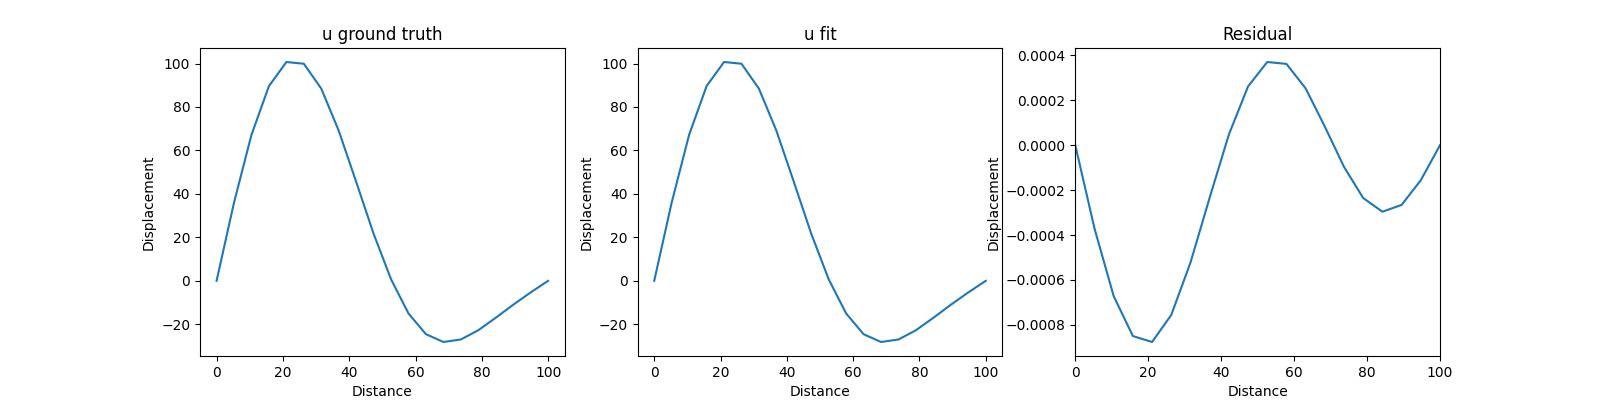

In [287]:
x = modes_depths
t = np.linspace(0, 100)

# Adding control variables and control variable names to lists:
control_labels = ['n0', 'n1', 'n2']
control_values = np.empty((len(x), len(control_labels)))
for i in range(len(control_labels)): control_values[:, i] = modes[:, i]

x = modes_depths
w = [2, 1, 5] # Temporal frequency
c = [1, 4, 2] # Mode amplitude
u = c[0] * modes[:, 0] + c[1] * modes[:, 1] + c[2] * modes[:, 2] # /np.max(np.abs(W[0,:,n]))
omega = 2

u_sol = u

u = np.zeros((len(x)))
u[:] = u_sol
u_dot = np.zeros((len(x)))
u_dot = w[0] * modes[:, 0] + w[1] * modes[:, 1] + w[2] * modes[:, 2]

# Setting up function library
library_functions = [
    lambda x: x,
]
library_function_names = [
    lambda x: x,
]

# Control variables function library
parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=False)

# u and u' function libraray
pde_lib = ps.PolynomialLibrary(degree=1)

lib = ps.ParameterizedLibrary(
    feature_library=pde_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=len(control_labels)
)

# Set up model and fit the model
feat_names = ['u']
feat_names.extend(control_labels)

optimizer = ps.SINDyPI(
    threshold=1e-1, max_iter=10000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)

# optimizer = ps.STLSQ(
#     threshold=2, # 8e-2
#     max_iter=10000,
#     normalize_columns=True,
# )

model = ps.SINDy(feature_library=pde_lib, feature_names=feat_names, optimizer=optimizer)

model.fit(u, x_dot=u_dot, quiet=True, u=control_values)
u_dot_stlsq = model.predict(u, u=control_values)
model.print()

print("Ground truth coefficients = ", c)
min = np.percentile(u_dot_test[~np.isnan(u_dot_test)],1)
max = np.percentile(u_dot_test[~np.isnan(u_dot_test)],99)

# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(modes_depths, u)
plt.xlabel('Distance')
plt.ylabel('Displacement')
plt.title('u ground truth')
ax = plt.gca()

plt.subplot(1, 3, 2)
# print(np.shape(u_dot_stlsq))
u_dot_stlsq = np.reshape(u_dot_stlsq[:, 1], (len(x))) # u_dot_stlsq[:, 0, 1]
plt.plot(x, u_dot_stlsq) # u_dot_stlsq
plt.xlabel('Distance')
plt.ylabel('Displacement')
plt.title('u fit')
ax = plt.gca()

plt.subplot(1, 3, 3)
plt.plot(x, u_dot_stlsq - u)
plt.xlim([t[0], t[-1]])
plt.xlabel('Distance')
plt.ylabel('Displacement')
plt.title('Residual')
ax = plt.gca()

## Sinusoidal SINDy with basis functions as control vars

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
1 1 = -10.947 1 u + 4.443 n0 1 + 6.669 n1 1 + 2.963 n2 1
1 u = -0.091 1 1 + 0.406 n0 1 + 0.609 n1 1 + 0.271 n2 1
n0 1 = 0.225 1 1 + 2.464 1 u + -1.501 n1 1 + -0.667 n2 1
n0 u = 0.022 1 1 + -0.045 1 u + -0.076 n0 1 + 0.006 n1 1 + 0.411 n1 u + -0.056 n2 1 + 0.118 n2 u
n1 1 = 0.150 1 1 + 1.641 1 u + -0.666 n0 1 + -0.444 n2 1
n1 u = 0.106 1 1 + 0.012 1 u + 0.025 n0 1 + 0.376 n0 u + -0.059 n1 1 + 0.176 n2 1 + 0.163 n2 u
n2 1 = 0.338 1 1 + 3.695 1 u + -1.500 n0 1 + -2.251 n1 1
n2 u = 0.033 1 1 + 0.042 1 u + -0.012 n0 1 + 0.113 n0 u + 0.141 n1 1 + 0.170 n1 u + -0.133 n2 1
Ground truth coefficients =  [1, 3, 2]
(1000, 8)


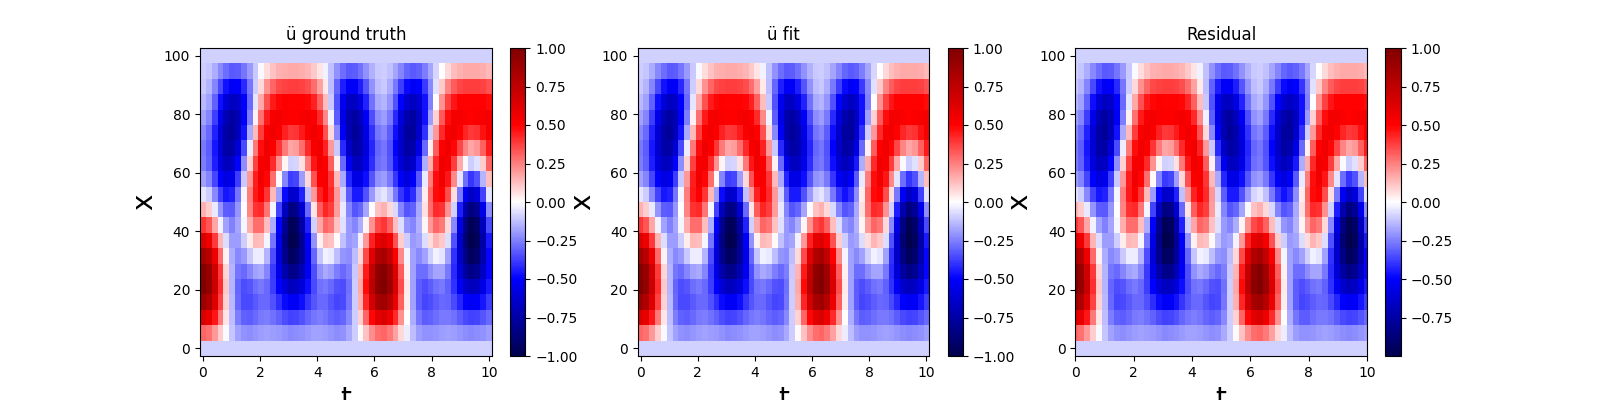

In [307]:
t = np.linspace(0, 100, 50)/10

# Adding control variables and control variable names to lists:
control_vars_names = ['n0', 'n1', 'n2']
control_vars_filled = np.empty((len(x), len(t), len(control_vars_names)))

x = modes_depths
w = [3, 1, 2] # Temporal frequenncy
c = [1, 3, 2] # Component amplitude
u = np.zeros((len(x), len(t), 1))
# Fill in control variables array
for i in range(len(control_vars_names)): 
    for j in range(len(t)): control_vars_filled[:, j, i] = np.cos(w[i] * t[j]) * modes[:, i]
    # Normalize each control variable array
    control_vars_filled[:, :, i] = (control_vars_filled[:, :, i] - np.min(control_vars_filled[:, :, i])) / (np.max(control_vars_filled[:, :, i]) - np.min(control_vars_filled[:, :, i]))
    control_vars_filled[:, :, i] = 2 * control_vars_filled[:, :, i] - 1

# Create the artificial data array u
for i in range(len(t)): u[:, i, 0] = np.cos(w[0] * t[i]) * c[0] * modes[:, 0] + np.cos(w[1] * t[i]) * c[1] * modes[:, 1] + np.cos(w[2] * t[i]) * c[2] * modes[:, 2] # /np.max(np.abs(W[0,:,n]))

# Normalize u
u = (u - np.min(u)) / (np.max(u) - np.min(u))
u = 2 * u - 1

# Set up x, t, and u variables
dt = t[1] - t[0]
dx = x[1] - x[0]

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

# Setting up function library
library_functions = [
    lambda x: x,
]
library_function_names = [
    lambda x: x,
]

# Control variables function library
parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

# u and u' function libraray
pde_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

lib = ps.ParameterizedLibrary(
    feature_library=pde_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=len(control_vars_names)
)

optimizer = ps.SINDyPI(
    threshold=0, max_iter=10000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)

# Set up model and fit the model
feat_names = ['u']
feat_names.extend(control_vars_names)

model = ps.SINDy(feature_library=lib, feature_names=feat_names, optimizer=optimizer)

model.fit(u, x_dot=u_dot, u=control_vars_filled, quiet=True)
model.print()
print("Ground truth coefficients = ", c)

u_dot_stlsq = model.predict(u, control_vars_filled)

print(np.shape(u_dot_stlsq))
min = -1
max = 1

# Make fancy plot comparing derivative. In this case we are only looking at the u = ... equation
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t, x, u[:, :, 0],
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü ground truth')
ax = plt.gca()

plt.subplot(1, 3, 2)
u_dot_stlsq = np.reshape(u_dot_stlsq[:, 1], (len(x), len(t)))
plt.pcolormesh(t, x, u_dot_stlsq,
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü fit')
ax = plt.gca()

plt.subplot(1, 3, 3)
plt.pcolormesh(t, x, u_dot_stlsq[:, :] - u[:,:,0],
            cmap='seismic') 
# To validate the model you can plot the sindy soln -0.091 + 0.406*control_vars_filled[:,:,0] + 0.609*control_vars_filled[:,:,1] + 0.271*control_vars_filled[:,:,2]
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.xlim([t[0], t[-1]])
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

## Propogating wave SINDy Fit

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
1 1 = 1.774 n0 u + 0.003 n1 1 + 0.306 n1 u + 0.015 n2 1
1 u = -0.002 1 1 + 0.899 n0 1 + 0.296 n1 1 + 0.094 n2 1
n0 1 = 0.002 1 1 + 1.093 1 u + -0.325 n1 1 + -0.105 n2 1
n0 u = 0.191 1 1 + 0.290 n1 u + -0.035 n2 1
n1 1 = 0.009 1 1 + 3.178 1 u + -2.874 n0 1 + -0.313 n2 1
n1 u = 0.026 1 1 + 0.202 n0 u + 0.092 n2 1
n2 1 = 0.027 1 1 + 8.545 1 u + -7.753 n0 1 + -2.578 n1 1 + 0.038 n1 u
n2 u = 0.001 1 1 + 0.089 n1 1 + 0.002 n1 u
Ground truth equation: u = 3 n0 + 2 n1 + 1 n2 


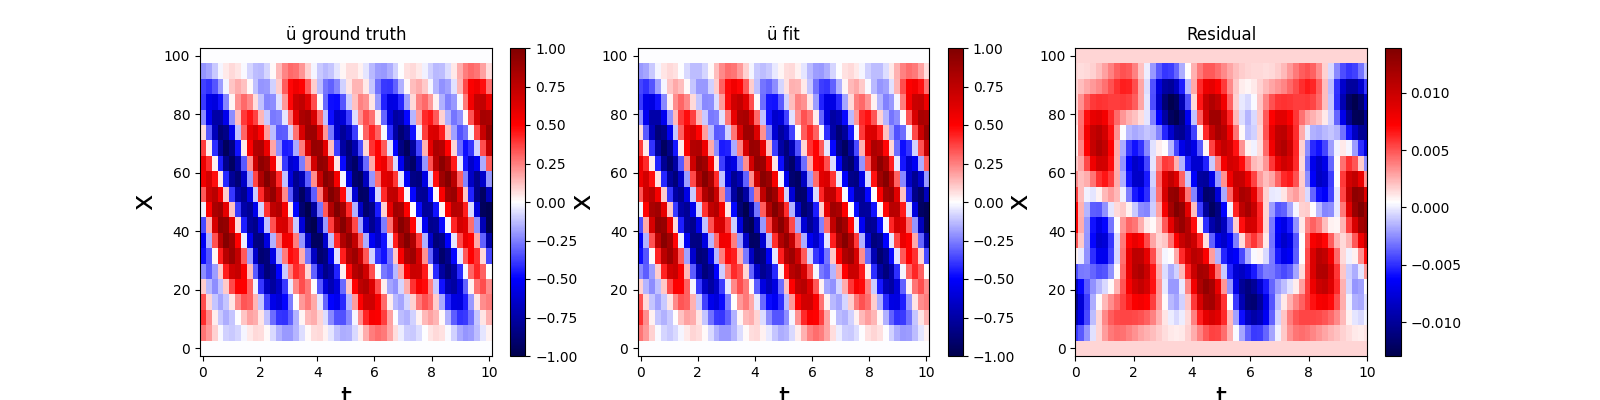

In [305]:
# Note: Right now this fit is simply using eigenmodes of the exact propogation speed that is in the final result, making it easy for SINDy. 
# Ideally, we would have a large library of propogation speeds that SINDy would have to choose from and could try to decompose the u matrix in terms of

t = np.linspace(0, 100, 50)/10

# Adding control variables and control variable names to lists:
control_vars_names = ['n0', 'n1', 'n2']
control_vars_filled = np.empty((len(x), len(t), len(control_vars_names)))

x = modes_depths
w = [3, 1, 2] # Temporal frequency
c = [3, 2, 1] # Amplitude of each mode
k = [1e-1, 0, 0] # Spatial frequency
u = np.zeros((len(x), len(t), 1))

# Fill in control variables array
for i in range(len(control_vars_names)): 
    for j in range(len(t)): control_vars_filled[:, j, i] = np.cos(x*k[i] + w[i] * t[j]) * modes[:, i]
    # Normalize each control variable array
    control_vars_filled[:, :, i] = (control_vars_filled[:, :, i] - np.min(control_vars_filled[:, :, i])) / (np.max(control_vars_filled[:, :, i]) - np.min(control_vars_filled[:, :, i]))
    control_vars_filled[:, :, i] = 2 * control_vars_filled[:, :, i] - 1

# Create the artificial data array u
for i in range(len(t)): u[:, i, 0] = np.cos(x * k[0] + w[0] * t[i]) * c[0] * modes[:, 0] + np.cos(x * k[1] + w[1] * t[i]) * c[1] * modes[:, 1] + np.cos(x * k[2] + w[2] * t[i]) * c[2] * modes[:, 2] # /np.max(np.abs(W[0,:,n]))

# Normalize u
u = (u - np.min(u)) / (np.max(u) - np.min(u))
u = 2 * u - 1

# Set up x, t, and u variables
dt = t[1] - t[0]
dx = x[1] - x[0]

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

# Setting up function library
library_functions = [
    lambda x: x,
]
library_function_names = [
    lambda x: x,
]

# Control variables function library
parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

# u function libraray
pde_lib = ps.PolynomialLibrary(degree=1, include_bias=True)
# Use this library for time derivatives
# multiindices=np.array([[0,1],[0,2],[1,0],[2,0]])
# pde_lib = ps.PDELibrary(library_functions=library_functions,
#                         function_names=library_function_names,
#                         derivative_order=1, spatial_grid=x, temporal_grid=t,
#                         include_bias=True, is_uniform=True,implicit_terms=True, multiindices=multiindices)


lib = ps.ParameterizedLibrary(
    feature_library=pde_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=len(control_vars_names)
)

optimizer = ps.SINDyPI(
    threshold=3, max_iter=10000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)

# Set up model and fit the model
feat_names = ['u']
feat_names.extend(control_vars_names)

model = ps.SINDy(feature_library=lib, feature_names=feat_names, optimizer=optimizer)

model.fit(u, x_dot=u_dot, u=control_vars_filled, quiet=True)
model.print()

print("Ground truth equation: u = %d n0 + %d n1 + %d n2 " %(c[0], c[1], c[2]))

u_dot_stlsq = model.predict(u, control_vars_filled)

min = -1
max = 1

# Make fancy plot comparing derivative. In this case we are only looking at the u = ... equation
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t, x, u[:, :, 0],
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü ground truth')
ax = plt.gca()

plt.subplot(1, 3, 2)
u_dot_stlsq = np.reshape(u_dot_stlsq[:,1], (len(x), len(t)))
plt.pcolormesh(t, x, u_dot_stlsq,
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü fit')
ax = plt.gca()

plt.subplot(1, 3, 3)
plt.pcolormesh(t, x, u_dot_stlsq[:, :] - u[:,:,0],
            cmap='seismic')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.xlim([t[0], t[-1]])
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()